# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [5]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [39]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [40]:
# DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
# download_url(DAASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [41]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [42]:
your_name = "hizuka" # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [43]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [44]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()


,age,sex,bmi,children,smoker,charges
1109,45,male,21.36750,3,no,10498.541030
38,35,male,38.50350,1,yes,48524.617086
702,53,male,43.54350,0,no,11595.258566
185,36,male,43.98975,3,yes,53379.071201
958,43,male,36.70800,1,yes,50061.750108


Let us answer some basic questions about the dataset. 


**Q1: How many rows does the dataset have?**

In [45]:
num_rows = len(dataframe)
print(num_rows)

1271


**Q2: How many columns doe the dataset have**

In [46]:
num_cols = len(dataframe.columns)
print(num_cols)

6


**Q3: What are the column titles of the input variables?**

In [54]:
input_cols = dataframe.columns
print(input_cols)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges'], dtype='object')


**Q4: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [48]:
import numpy as np
categorical_cols = dataframe.select_dtypes(exclude=np.number).columns
print(categorical_cols)

Index(['sex', 'smoker'], dtype='object')


**Q5: What are the column titles of output/target variable(s)?**

In [49]:
output_cols = dataframe[["charges"]].columns
print(output_cols)

Index(['charges'], dtype='object')


**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

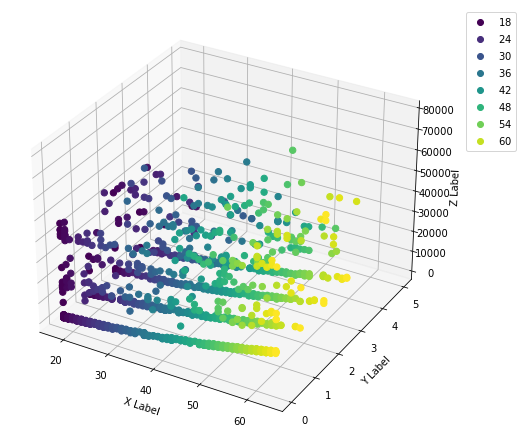

In [50]:

import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# generate data
n = 200
x = dataframe['age']
y = dataframe['children']
z = dataframe['charges']


# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=x, marker='o',  alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


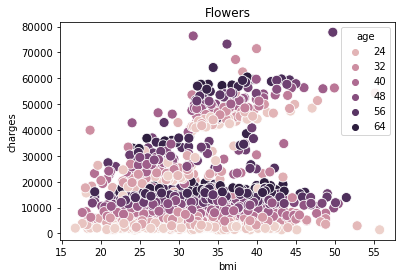

In [51]:
# Create a scatter plot
sns.scatterplot(dataframe['bmi'], # X-axis
                dataframe['charges'],
                dataframe['age'],# Y-axis
                  # Dot color
                s=100);

# Chart title
plt.title("Flowers");

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [55]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [61]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array = np.float32(inputs_array)
targets_array = np.float32(targets_array)
inputs_array, targets_array

(array([[3.1000000e+01, 0.0000000e+00, 3.0555000e+01, 0.0000000e+00,
         0.0000000e+00, 4.5887764e+03],
        [1.8000000e+01, 0.0000000e+00, 4.0598251e+01, 2.0000000e+00,
         0.0000000e+00, 4.1398945e+03],
        [3.4000000e+01, 1.0000000e+00, 2.6565001e+01, 2.0000000e+00,
         1.0000000e+00, 2.3146443e+04],
        ...,
        [5.3000000e+01, 1.0000000e+00, 4.3543499e+01, 0.0000000e+00,
         0.0000000e+00, 1.1595259e+04],
        [3.6000000e+01, 1.0000000e+00, 4.3989750e+01, 3.0000000e+00,
         1.0000000e+00, 5.3379070e+04],
        [4.3000000e+01, 1.0000000e+00, 3.6708000e+01, 1.0000000e+00,
         1.0000000e+00, 5.0061750e+04]], dtype=float32),
 array([[ 4588.7764],
        [ 4139.8945],
        [23146.443 ],
        ...,
        [11595.259 ],
        [53379.07  ],
        [50061.75  ]], dtype=float32))

**Q6: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [63]:
inputs = torch.from_numpy(inputs_array)
targets = torch.from_numpy(targets_array)

In [64]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [65]:
dataset = TensorDataset(inputs, targets)

**Q7: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [67]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset,[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length
print(len(train_ds),len(val_ds))

1081 190


Finally, we can create data loaders for training & validation.

**Q8: Pick a batch size for the data loader.**

In [68]:
batch_size = 128

In [69]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
print(val_loader)

Let's look at a batch of data to verify everything is working fine so far.

In [71]:
for xb, yb in train_loader:
    print("inputs:", xb.shape)
    print("targets:", yb.shape)
    break

inputs: torch.Size([128, 6])
targets: torch.Size([128, 1])


## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [73]:
input_size = len(input_cols)
output_size = len(output_cols)
print(input_size,output_size)

6 1


In [74]:
import torch.nn.functional as F



**Q9: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [224]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  
        
    def forward(self, xb):
        out = self.linear(xb)                      
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out,targets)                          
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                 
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

### test model output:


In [225]:
model = InsuranceModel()
for inputs, labels in train_loader:
    print(inputs.shape)
    outputs = model(inputs)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:3].data)
print("label : \n",labels[:3])

loss = F.l1_loss(outputs[:3].data,labels[:3])
print("loss: ",loss)

torch.Size([128, 6])
outputs.shape :  torch.Size([128, 1])
Sample outputs :
 tensor([[2029.0035],
        [2793.0645],
        [2254.7021]])
label : 
 tensor([[16124.8555],
        [22226.1562],
        [17925.0566]])
loss:  tensor(16399.7676)


In [226]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [227]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2441,  0.3778, -0.2377, -0.2934,  0.2072,  0.3560]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.2555], requires_grad=True)]

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [228]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q10: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [229]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 11467.591796875}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q11: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [230]:
epochs = 100
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 2314833.5000
Epoch [40], val_loss: 1911799.0000
Epoch [60], val_loss: 1484681.1250
Epoch [80], val_loss: 2653997.5000
Epoch [100], val_loss: 249746.4688


In [231]:
epochs = 100
lr = 1e-4
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 23523.0039
Epoch [40], val_loss: 750.4875
Epoch [60], val_loss: 7495.7070
Epoch [80], val_loss: 10756.9707
Epoch [100], val_loss: 28072.8008


In [232]:
epochs = 100
lr = 1e-6
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 181.2352
Epoch [40], val_loss: 133.9799
Epoch [60], val_loss: 79.2047
Epoch [80], val_loss: 100.6923
Epoch [100], val_loss: 152.0549


In [233]:
epochs = 500
lr = 1e-6
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 208.3706
Epoch [40], val_loss: 287.6995
Epoch [60], val_loss: 168.2537
Epoch [80], val_loss: 60.2530
Epoch [100], val_loss: 193.2690
Epoch [120], val_loss: 183.0303
Epoch [140], val_loss: 76.6452
Epoch [160], val_loss: 126.8062
Epoch [180], val_loss: 203.4149
Epoch [200], val_loss: 225.0773
Epoch [220], val_loss: 243.0620
Epoch [240], val_loss: 113.9636
Epoch [260], val_loss: 108.3038
Epoch [280], val_loss: 74.0379
Epoch [300], val_loss: 174.1008
Epoch [320], val_loss: 30.9723
Epoch [340], val_loss: 35.8303
Epoch [360], val_loss: 145.9443
Epoch [380], val_loss: 215.6888
Epoch [400], val_loss: 253.9680
Epoch [420], val_loss: 131.8471
Epoch [440], val_loss: 165.6224
Epoch [460], val_loss: 333.7001
Epoch [480], val_loss: 174.9269
Epoch [500], val_loss: 152.2698


In [191]:
epochs = 500
lr = 1e-3
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 265454.4375
Epoch [40], val_loss: 152463.9062
Epoch [60], val_loss: 217103.1719
Epoch [80], val_loss: 87926.0156
Epoch [100], val_loss: 115281.3125
Epoch [120], val_loss: 56984.2656
Epoch [140], val_loss: 177869.6250
Epoch [160], val_loss: 236590.6562
Epoch [180], val_loss: 25631.6914
Epoch [200], val_loss: 84731.0312
Epoch [220], val_loss: 79499.3516
Epoch [240], val_loss: 471.9165
Epoch [260], val_loss: 130825.8594
Epoch [280], val_loss: 199504.6250
Epoch [300], val_loss: 122.1438
Epoch [320], val_loss: 257506.1250
Epoch [340], val_loss: 133825.3750
Epoch [360], val_loss: 139458.2031
Epoch [380], val_loss: 176993.8125
Epoch [400], val_loss: 111759.8281
Epoch [420], val_loss: 320543.5625
Epoch [440], val_loss: 33950.5117
Epoch [460], val_loss: 5259.2061
Epoch [480], val_loss: 132952.2031
Epoch [500], val_loss: 208568.1875


**Q12: What is the final validation loss of your model?**

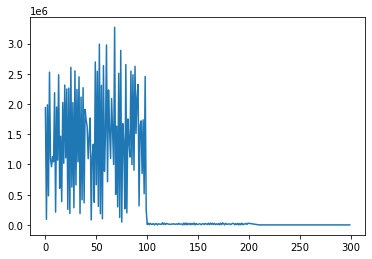

In [234]:
hist = history1 + history2 + history3 
loss = []
for value in hist:
    loss.append(value['val_loss'])
    
plt.plot(loss)

## Step 5: Make predictions using the trained model

**Q13: Complete the following function definition to make predictions on a single input**

In [235]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                 # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [236]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([4.9000e+01, 1.0000e+00, 3.2445e+01, 0.0000e+00, 1.0000e+00, 4.8468e+04])
Target: tensor([48467.6875])
Prediction: tensor([48136.5078])


In [237]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([4.9000e+01, 1.0000e+00, 3.2917e+01, 1.0000e+00, 0.0000e+00, 1.1334e+04])
Target: tensor([11333.9697])
Prediction: tensor([11213.3311])


In [238]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([3.9000e+01, 1.0000e+00, 3.1080e+01, 4.0000e+00, 0.0000e+00, 9.1650e+03])
Target: tensor([9164.9658])
Prediction: tensor([9062.3438])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039